[VAE](https://en.wikipedia.org/wiki/Variational_autoencoder)

[Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

## GP 1D Data Generator

In [ ]:
#import os,sys
#sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
import numpy as np  
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class GP1D(Dataset):
    def __init__(self, dataPoints=100, samples=10000, ingrid=True, x_lim = 1,
                        seed=np.random.randint(20), kernel='rbf',ls = 0.1, nu=2.5):
        self.dataPoints = dataPoints
        self.samples = samples
        self.ingrid = ingrid
        self.x_lim = x_lim
        self.seed = seed
        self.Max_Points = 2 * dataPoints
        self.ls = ls
        self.nu = nu
        self.kernel = kernel
        np.random.seed(self.seed)
        self.evalPoints, self.data = self.__simulatedata__()
    
    def __len__(self):
        return self.samples
    
    def __getitem__(self, idx=0):
        return(self.evalPoints[:,idx], self.data[:,idx])


    def __simulatedata__(self):
        if self.kernel=='rbf':
            gp = GaussianProcessRegressor(kernel=RBF(length_scale=self.ls))
        elif self.kernel=='matern':
            gp = GaussianProcessRegressor(kernel=Matern(length_scale=self.ls, nu=self.nu))
        else:
            return None
        if (self.ingrid):
            X_ = np.linspace(-self.x_lim, self.x_lim, self.dataPoints)
            y_samples = gp.sample_y(X_[:, np.newaxis], self.samples)
            # print(X_.shape, y_samples.shape)
            return (X_.repeat(self.samples).reshape(X_.shape[0],self.samples) ,
                        y_samples)
        else:
            X_ = np.linspace(-self.x_lim, self.x_lim, self.Max_Points)
            X_ = np.random.choice(X_, (self.dataPoints,self.samples))
            X_.sort(axis=0)
            y_samples = np.zeros((self.dataPoints,self.samples))
            for idx in range(self.samples):
                x_ = X_[:,idx]
                y_samples[:,idx] = gp.sample_y(x_[:, np.newaxis]).reshape(self.dataPoints,)
            # print(X_.shape, y_samples.shape)
            return (X_, y_samples)

___

## VAE = Encoder + Decoder

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.distributions import Normal

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.mu = nn.Linear(hidden2_dim, z_dim)
        self.std = nn.Linear(hidden2_dim, z_dim)

    def forward(self, x):
        hidden1 = torch.tanh(self.linear1(x))
        hidden2 = torch.tanh_(self.linear2(hidden1))
        z_mu = self.mu(hidden2)
        z_std = self.std(hidden2)

        return z_mu, z_std

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden1_dim, hidden2_dim, input_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(z_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.out = nn.Linear(hidden2_dim, input_dim)

    def forward(self, z):
        hidden1 = torch.tanh(self.linear1(z))
        hidden2 = torch.tanh(self.linear2(hidden1))
        pred = self.out(hidden2)

        return pred

torch.randn_like(input, *, dtype=None, layout=None, device=None, requires_grad=False, memory_format=torch.preserve_format) 

Returns a tensor with the same size as input filled with random numbers from a normal **distribution with mean 0 and variance 1**

torch.randn_like(input) is equivalent to torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device).

In [67]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, hidden1_dim, hidden2_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden1_dim, hidden2_dim, input_dim)

    def reparameterize(self, z_mu, z_std):
        if self.training:
            sd = torch.exp(z_std / 2)
            #eps = torch.randn_like(sd)
            eps = Normal(0.0, 0.1).sample(sd.size())
            return eps.mul(sd).add_(z_mu)
            #return Normal(z_mu, sd).sample()
        else:
            return z_mu

    def forward(self, x):
        z_mu, z_std = self.encoder(x)
        z_sample = self.reparameterize(z_mu, z_std)
        pred = self.decoder(z_sample)
        return pred, z_mu, z_std

___

## Loss Function

In [68]:
def compute_loss(x, x_pred, mean, log_sd):
    RCL = F.mse_loss(x_pred, x, reduction='sum')
    KLD = -0.5*torch.sum(1+log_sd - mean.pow(2) - log_sd.exp())
    return RCL + KLD

___

In [69]:
   ###### intializing data and model parameters
input_dim = 100
batch_size = 500    
hidden_dim1 = 64
hidden_dim2 = 32
z_dim = 20
samples = 100000

In [70]:
###### creating data, model and optimizer
train_ds = GP1D(dataPoints=input_dim, samples=samples, ls=0.1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [71]:
len(train_ds)

100000

In [72]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '10 different function realizations at fixed 100 points\nsampled from a Gaussian process with RBF')

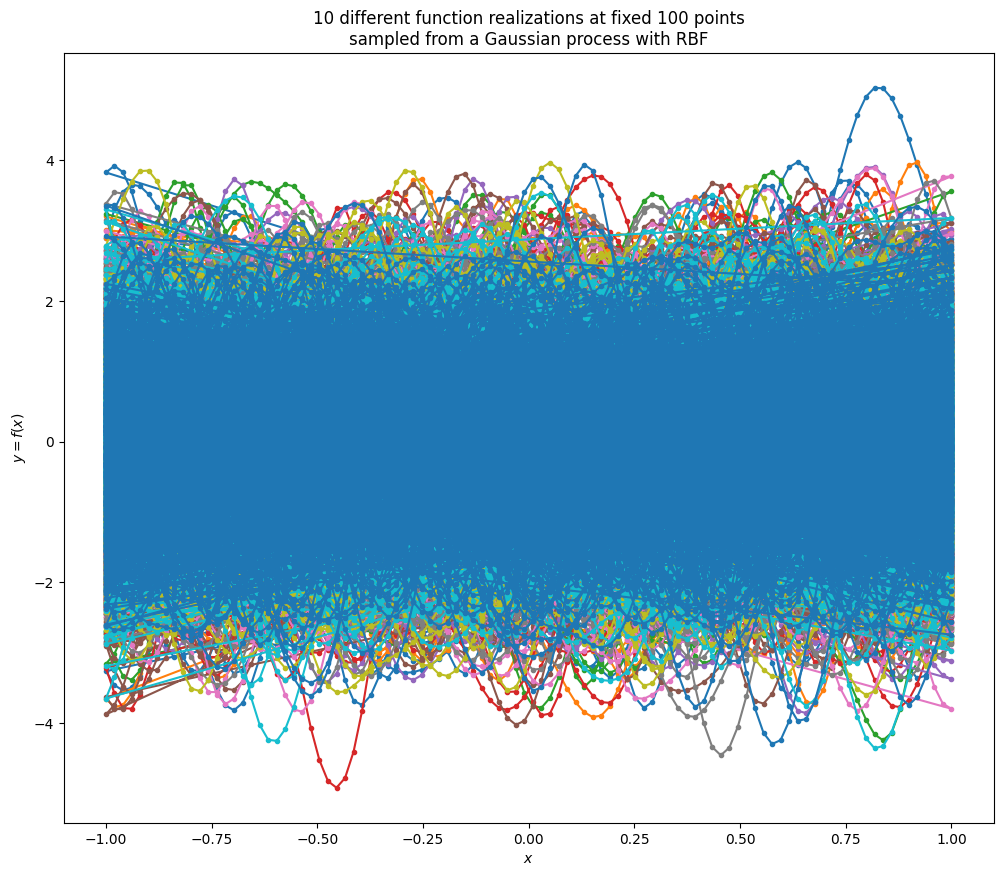

In [73]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, dt in enumerate(train_dl):
        ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), marker='o', markersize=3)
        if no > 9: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('10 different function realizations at fixed 100 points\n'
    'sampled from a Gaussian process with RBF')

___

In [74]:
import torch.optim as optim 

In [75]:
model = VAE(input_dim, hidden_dim1, hidden_dim2, z_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

## Training

In [76]:
from tqdm import tqdm, trange

In [77]:
t = trange(100)
for e in t:
    model.train()
    total_loss = 0
    for i, x in enumerate(train_dl):
        x = x[1].float().to(device)
        optimizer.zero_grad()
        x_pred, z_mu, z_sd = model(x)
        loss = compute_loss(x, x_pred, z_mu, z_sd)
        loss.backward()

        total_loss += loss.item()

        optimizer.step()
    t.set_description(f'Loss is {total_loss/(samples*input_dim):.3}')

Loss is 0.0687: 100%|██████████| 100/100 [04:09<00:00,  2.49s/it]


## Eval

In [78]:
model.eval()
z = torch.randn(5, z_dim).to(device)

with torch.no_grad():
    x_sample = model.decoder(z)

Text(0.5, 1.0, '5 different function realizations at fixed 100 points\nsampled from a VAE learned with prior as GP (RBF)')

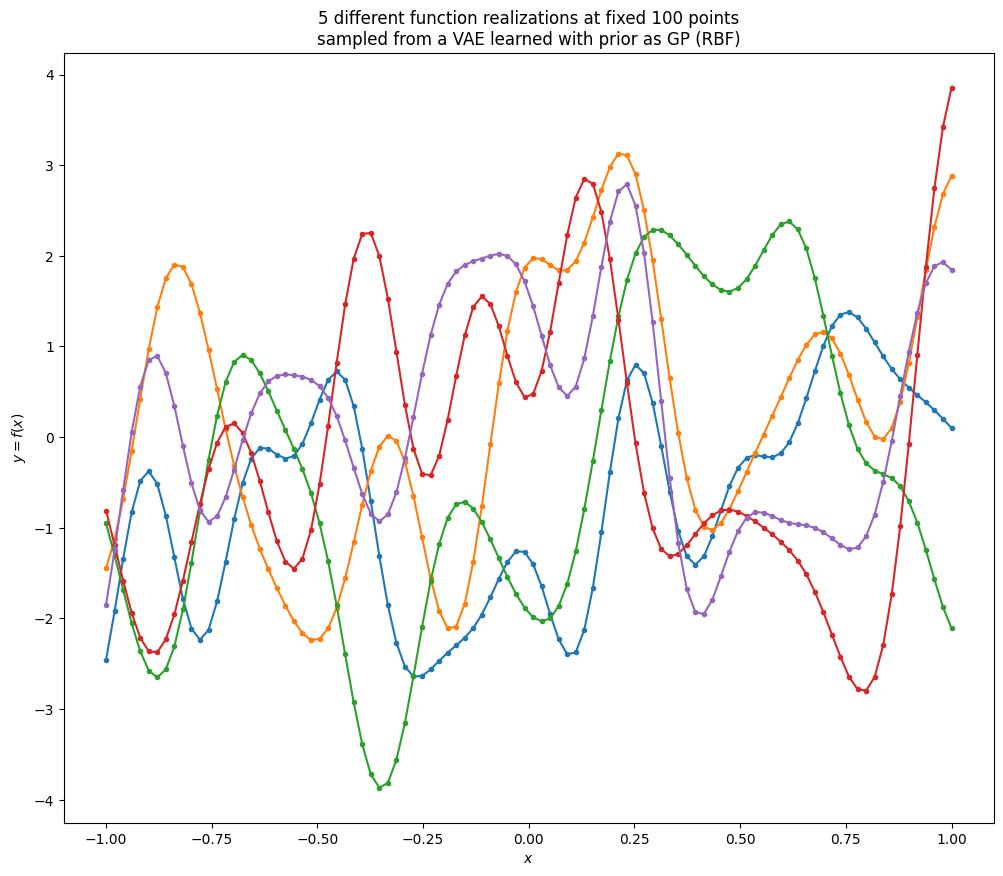

In [79]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, y in enumerate(x_sample):
    ax.plot(train_ds.evalPoints[:,0], y.cpu().numpy(), marker='o', markersize=3)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('5 different function realizations at fixed 100 points\n'
    'sampled from a VAE learned with prior as GP (RBF)')
    #plt.savefig('plots/sample_prior_vae_1d_fixed.pdf')

## Inference

In [80]:
observed = GP1D(input_dim, 1, ls=0.1)

In [81]:
observed[0][1]

array([ 1.13597143,  0.85712347,  0.66362773,  0.57750194,  0.59688305,
        0.69760687,  0.84147169,  0.98708298,  1.09892976,  1.15219898,
        1.13330356,  1.03779183,  0.86778718,  0.63067498,  0.33980329,
        0.01657309, -0.30826404, -0.59703341, -0.81287108, -0.93078219,
       -0.94639274, -0.8763559 , -0.74873884, -0.58846156, -0.40684066,
       -0.20186879,  0.03162704,  0.28973308,  0.55398642,  0.79635889,
        0.99118679,  1.12671985,  1.21032089,  1.26563692,  1.32374819,
        1.41172106,  1.54190751,  1.70513164,  1.87072604,  1.99515895,
        2.03793127,  1.97939047,  1.83244519,  1.64121357,  1.46490498,
        1.3526121 ,  1.32024582,  1.34104671,  1.35519456,  1.29489144,
        1.11383996,  0.8081707 ,  0.42013801,  0.02364445, -0.30192408,
       -0.49887258, -0.54896971, -0.47578526, -0.33221215, -0.17977355,
       -0.06877984, -0.026406  , -0.05493914, -0.1378353 , -0.24905509,
       -0.36163077, -0.45332878, -0.50918465, -0.52184093, -0.49

In [82]:
model = model.to('cpu')

In [83]:
decoder_dict = model.decoder.state_dict()

In [84]:
decoder_dict

OrderedDict([('linear1.weight',
              tensor([[-1.6192e-02,  1.5725e-01,  4.1362e-02,  ..., -1.4676e-03,
                        4.3283e-02,  5.7612e-02],
                      [ 2.2157e-05, -1.1173e-01, -2.7379e-02,  ..., -5.4703e-02,
                        9.0752e-03, -6.5661e-02],
                      [ 2.2469e-02,  1.6027e-02,  8.8984e-03,  ...,  6.9466e-03,
                        1.0683e-01, -9.7319e-03],
                      ...,
                      [-3.1038e-02, -5.4969e-03, -7.5061e-03,  ...,  7.5000e-03,
                       -1.8637e-03,  1.6050e-02],
                      [ 1.1451e-02, -2.5508e-02,  6.4868e-02,  ..., -1.7336e-01,
                       -2.8892e-02, -4.5085e-02],
                      [-3.2952e-04, -4.8023e-04, -2.8622e-03,  ...,  1.4295e-03,
                        2.0391e-03,  2.1452e-03]])),
             ('linear1.bias',
              tensor([-2.0262e-03, -5.4875e-03, -2.1597e-04,  3.2498e-04,  1.4059e-03,
                      -3.9707e-03, 

In [85]:
f = observed[0][1]

In [86]:
decoder_dict['linear1.bias'].T

tensor([-2.0262e-03, -5.4875e-03, -2.1597e-04,  3.2498e-04,  1.4059e-03,
        -3.9707e-03,  4.6345e-04, -2.0492e-03,  2.9155e-04,  1.8825e-03,
        -3.5282e-03,  1.9635e-03, -5.4370e-04,  4.5445e-04,  7.3423e-04,
         1.1807e-03,  4.9903e-04,  3.9075e-04, -2.3724e-03, -6.5353e-04,
         1.4390e-04, -1.0799e-03, -4.0479e-03,  8.4584e-05, -7.8099e-04,
         2.8723e-04, -1.9683e-03, -2.7505e-03,  1.1763e-03, -4.1088e-04,
        -2.5507e-03,  5.0157e-04, -1.6771e-04, -1.8590e-03,  2.5672e-03,
        -2.1098e-03,  3.3171e-03, -2.0081e-03,  3.1723e-04,  1.0499e-03,
        -8.1386e-05, -2.0027e-03,  5.5095e-04, -4.5708e-03,  5.4661e-03,
        -9.3779e-05,  1.2203e-03,  1.7137e-03, -7.5009e-04, -7.7951e-03,
         2.2223e-03, -3.3969e-03,  1.2997e-03, -1.5807e-03,  1.7196e-03,
        -6.5009e-03, -4.4009e-03,  1.9107e-04, -8.8085e-05,  7.7354e-04,
        -2.8287e-03,  9.4028e-04,  7.1328e-03,  4.4233e-04])

In [87]:
y = f + np.random.randn(input_dim) * 0.1

In [88]:
stan_data = {
    "p": z_dim,
    "p1": hidden_dim1,
    "p2": hidden_dim2,
    'n': input_dim,
    "W1": decoder_dict['linear1.weight'].T.numpy(),
    'B1': decoder_dict['linear1.bias'].T.numpy(),
    'W2': decoder_dict['linear2.weight'].T.numpy(),
    "B2": decoder_dict['linear2.bias'].T.numpy(),
    "W3": decoder_dict['out.weight'].T.numpy(),
    "B3": decoder_dict['out.bias'].T.numpy(),
    'y': y
}

## Stan

In [89]:
import cmdstanpy

In [90]:
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.30.1
Install directory: /home/drclab/.cmdstan
CmdStan version 2.30.1 already installed


True

In [91]:
sm = cmdstanpy.CmdStanModel(stan_file='stan_1D.stan')

In [92]:
fit = sm.sample(data= stan_data, iter_sampling=2000, iter_warmup=500, chains=4)

17:07:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:07:08 - cmdstanpy - INFO - CmdStan done processing.


In [93]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,129.669000,0.068786,3.566040,123.186000,130.036000,134.907000,2687.67,341.118,1.002240
z[1],-0.094118,0.022423,0.974928,-1.699970,-0.097844,1.503890,1890.38,239.926,1.003180
z[2],0.327379,0.001171,0.057839,0.230787,0.326637,0.423055,2440.23,309.713,1.002450
z[3],-0.364783,0.000808,0.054952,-0.454997,-0.364672,-0.274545,4619.71,586.332,1.000550
z[4],0.257818,0.001066,0.086271,0.116015,0.258223,0.399279,6546.01,830.818,1.000530
...,...,...,...,...,...,...,...,...,...
y2[96],2.130960,0.001866,0.172755,1.842280,2.129930,2.413830,8568.63,1087.530,0.999675
y2[97],2.204840,0.001893,0.171245,1.920250,2.205120,2.487140,8182.60,1038.530,1.000130
y2[98],2.237640,0.001863,0.173549,1.955050,2.238120,2.525520,8677.24,1101.310,0.999942
y2[99],2.210630,0.001896,0.181456,1.911810,2.210640,2.508610,9156.19,1162.100,0.999842


In [94]:
out = fit.stan_variables()

In [95]:
fit.diagnose()

'Processing csv files: /tmp/tmp9l28bgl4/stan_1Dydip8e5z/stan_1D-20221105170705_1.csv, /tmp/tmp9l28bgl4/stan_1Dydip8e5z/stan_1D-20221105170705_2.csv, /tmp/tmp9l28bgl4/stan_1Dydip8e5z/stan_1D-20221105170705_3.csv, /tmp/tmp9l28bgl4/stan_1Dydip8e5z/stan_1D-20221105170705_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [96]:
out

{'z': array([[ 1.23483  ,  0.257577 , -0.359036 , ...,  0.100937 , -1.80797  ,
         -0.124084 ],
        [-0.201772 ,  0.353758 , -0.379398 , ...,  0.0609263, -1.68903  ,
          0.0807185],
        [-0.104616 ,  0.306616 , -0.321364 , ...,  0.123125 , -1.72631  ,
          0.0270891],
        ...,
        [ 1.70259  ,  0.245077 , -0.411089 , ...,  0.0509741, -1.73304  ,
         -0.0168136],
        [ 1.35405  ,  0.265527 , -0.386406 , ...,  0.141234 , -1.7877   ,
          0.0235767],
        [ 0.685095 ,  0.248946 , -0.392265 , ...,  0.113142 , -1.78536  ,
          0.0593283]]),
 'sigma2': array([0.152868, 0.182116, 0.170304, ..., 0.162356, 0.15654 , 0.152288]),
 'f': array([[0.898505, 0.875108, 0.831004, ..., 2.26649 , 2.22307 , 2.10481 ],
        [0.955582, 0.892452, 0.808081, ..., 2.20721 , 2.2516  , 2.22899 ],
        [0.842103, 0.808154, 0.755324, ..., 2.14487 , 2.16611 , 2.12275 ],
        ...,
        [0.878232, 0.850734, 0.801015, ..., 2.34143 , 2.32338 , 2.22667 ],
 

In [97]:
fit.save

AttributeError: Unknown variable name: save
Available variables are z, sigma2, f, y2

## Posterior Plotting

In [98]:
import arviz as az

array([[<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>]], dtype=object)

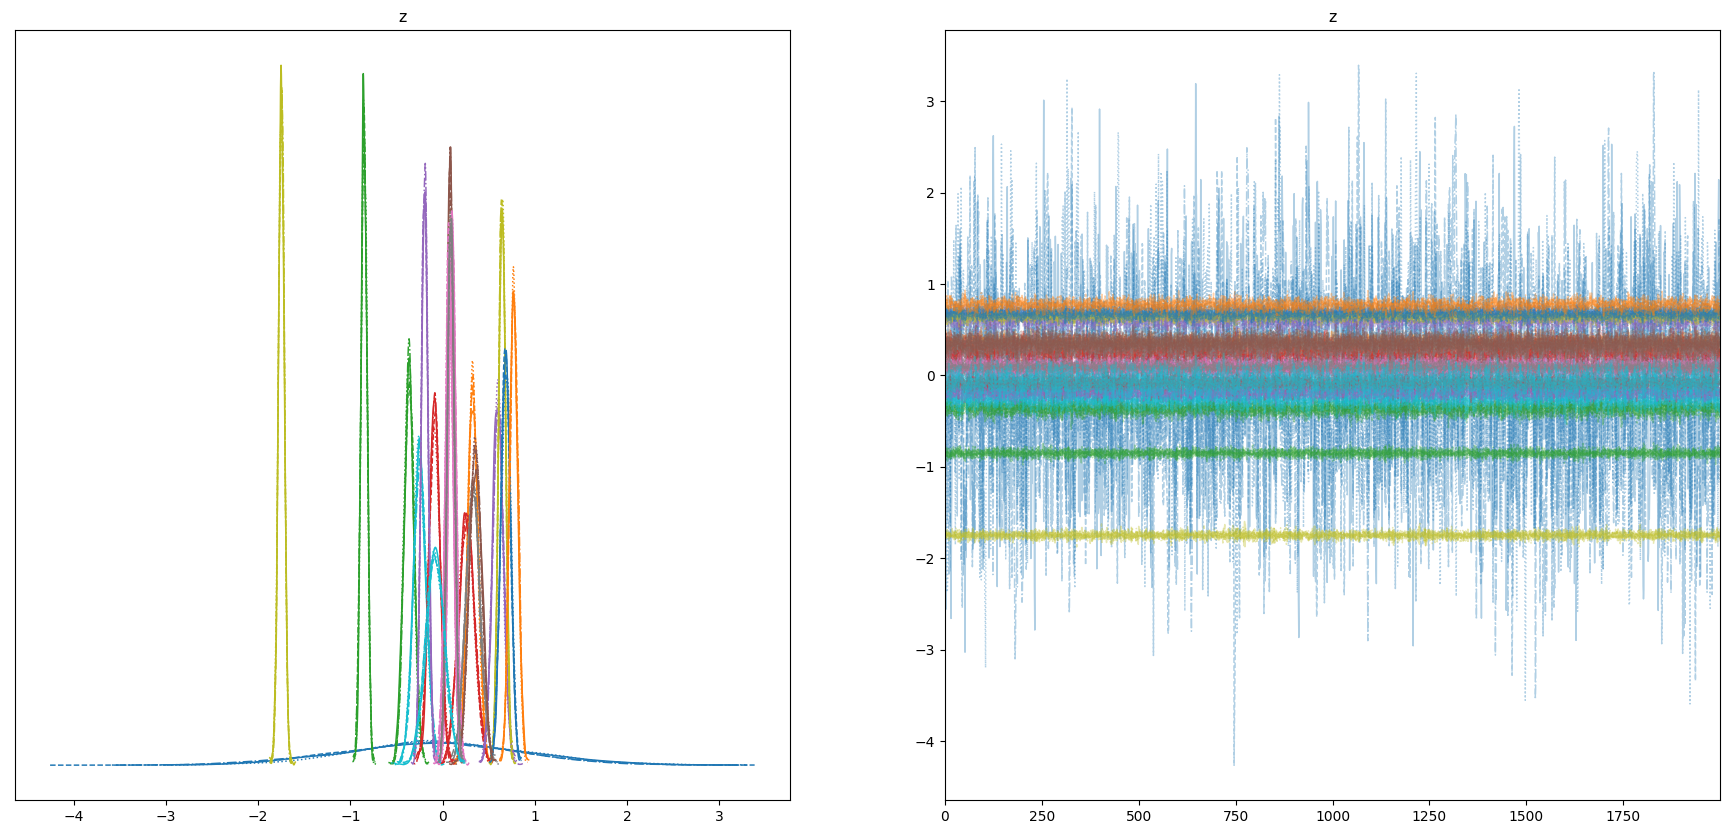

In [99]:
az.plot_trace(fit, var_names=["z"], figsize=(22,10))

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

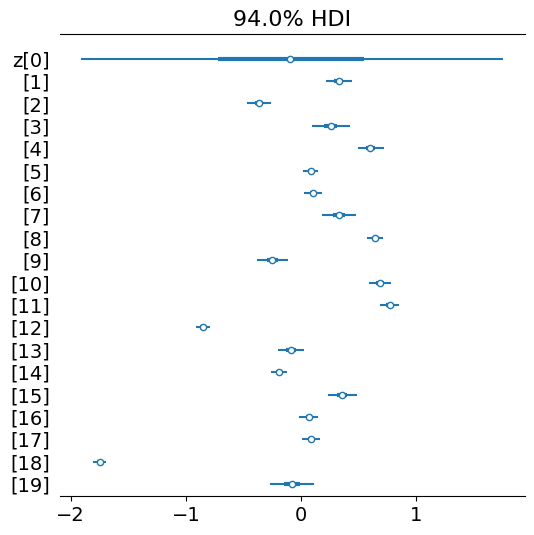

In [100]:
az.plot_forest(fit, var_names="z", combined=True)

In [101]:
import pandas as pd

In [102]:
datapoints = observed[0][0]
df = pd.DataFrame(out['y2'])

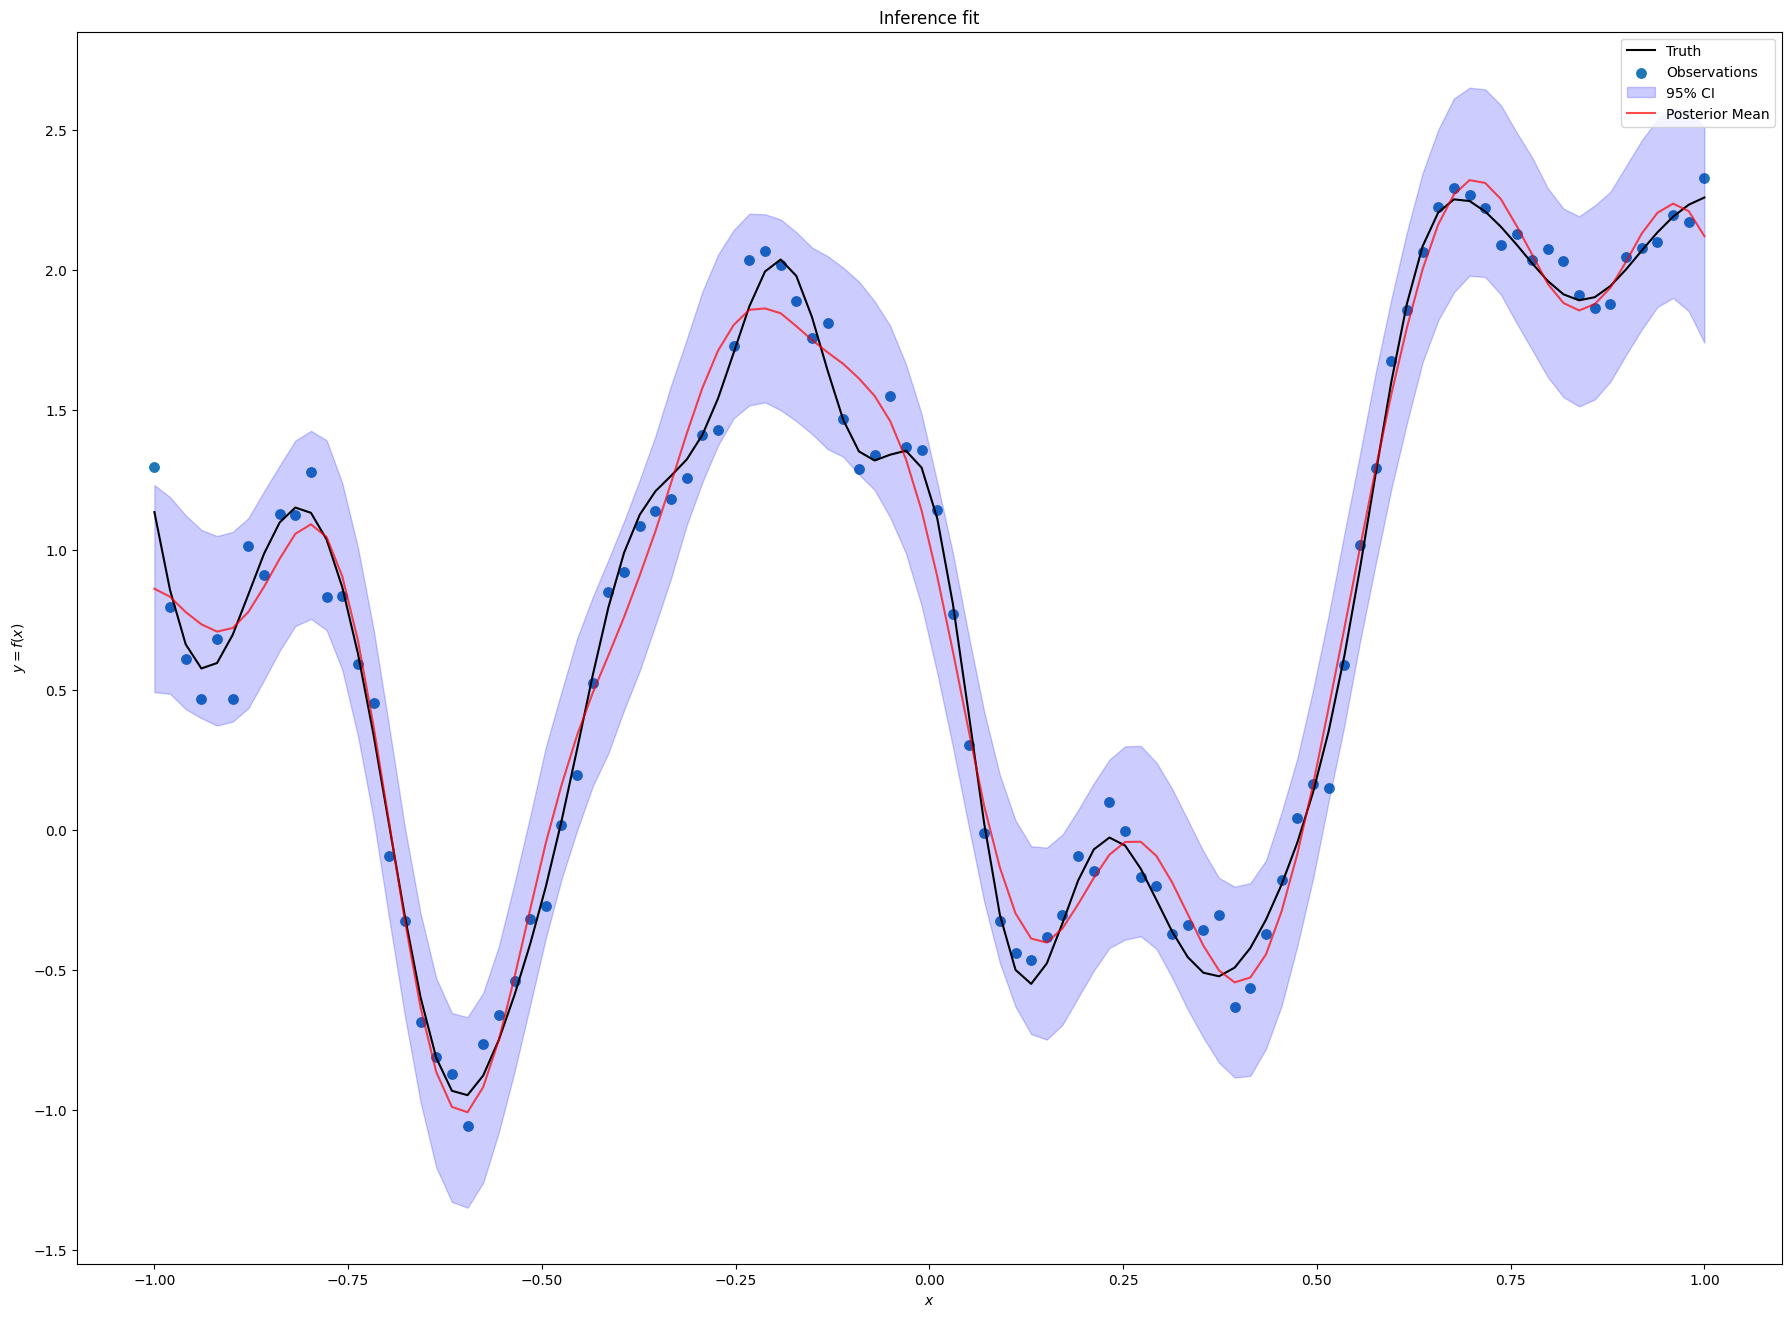

In [103]:
fig = plt.figure(figsize=(22,16))
ax = fig.add_subplot(111)
ax.plot(datapoints, f.reshape(-1,1), color="black", label="Truth")
ax.scatter(datapoints, y.reshape(-1,1), s=46, label="Observations")
ax.fill_between(datapoints, 
                df.quantile(0.025).to_numpy(), 
                df.quantile(0.975).to_numpy(),
                #facecolor = "blue",
                color="blue",
                alpha= 0.2,
                label = "95% CI"
)
ax.plot(datapoints, df.mean().to_numpy().reshape(-1,1), color="red", alpha=0.7,
    label="Posterior Mean"
)
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Inference fit')
ax.legend()
